# Using Levenshtein Distance for Fuzzy String Matching

There was a [tweet on 26th March 2020](https://twitter.com/lloydhardy/status/1375363511962980352?s=20) with a screenshot of some Home Office spending. I was curious about how easy it is to harvest, clean and summarise the spending data. The data were split across twelve CSV files, one for each month. [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) was used to combine the files by fuzzy matching supplier names as inconsistent values were used. I've previously used other methods such as [soundex](https://en.wikipedia.org/wiki/Soundex) and [metaphone](https://en.wikipedia.org/wiki/Metaphone), but these data presented more of a challenge.

**Examples of fuzzy supplier names used for matching:**

| Original | Fuzzy value |
| :--- | :--- |
| A1 ENVIRO SCIENCE | a1 enviro sciences |
| A1-ENVIRO SCIENCES. | a1 enviro sciences |
| --- | --- |
| W<span>WW.EQUIP4WORK</span>.CO.UK | equip4work |
| EQUIP4WORK | equip4work |

<br />

The article originally appeared in Byline Times as '[Home Office Fails to Explain Strange Expenses](https://bylinetimes.com/2021/03/24/home-office-fails-to-explain-strange-expenses/)'. The Home Office did respond 26-Mar-2021 to say that purchases were made for PPE and clothing for asylum seekers.

![Byline](images/byline.png)

## Source Data

* Home Office data [downloaded from here](https://www.gov.uk/government/publications/home-office-procurement-card-spend-over-500-2020) on 26-Mar-2021
* Data covers the 2020 calendar year
* Data published 19-Mar-2021

## Report

[Spending 2020](#Spending-2020) at the end of the report contains:
* Total spend for year: £2,097,376.09
* Chart and table of spending per month: March and April 2020 at the first lockdown have spike increase in spending and account for 58% of the 2020 spend.
* Table of top 20 supplier spend for 2020
* Table of top 20 spend from 01-Mar-2020 to 30-Apr-2020

![Total Spending per Month 2020](spend_per_month.png)

## Cleaned Data Files

The `Supplier` column had to be processed so that the data could be aggregated as supplier names aren't always consistent. [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) was used for fuzzy matching supplier names.

[cleaned_agg_spend.csv](cleaned_agg_spend.csv) contains data aggregated by supplier for 2020. Columns:

* supplier_fuzzy - the fuzzy match string used to link suppliers
* total_spend_supplier - total spend with supplier over year
* percent_share_spend - percentage of total spend with supplier 
* number_purchases - number of purchases made with supplier
* first_purchase - date first purchase made from supplier (yyyy-mm-dd)
* last_purchase - date last purchase made from supplier (yyyy-mm-dd)

[cleaned_spend.csv](cleaned_spend.csv) contains all rows from merging the original data in the calendar year 2020 CSV files. Columns:
 
 * Date
 * Amount
 * Supplier
 * supplier_clean - some preprocessing on `Supplier` names to help with the fuzzy matching
 * supplier_fuzzy - the fuzzy match string used to link suppliers


In [59]:
%matplotlib inline

from datetime import datetime
import re

from bs4 import BeautifulSoup
import requests

from fuzzywuzzy import fuzz
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Get Data from Online CSVs

There are multiple links to the data, we're interested in the `Download CSV` links only.

![CSV](images/ho_csv_link.png)

In [60]:
# The page contains links to the CSV files.
req = requests.get('https://www.gov.uk/government/publications/home-office-procurement-card-spend-over-500-2020')
assert req.status_code == 200

In [61]:
# There are multiple links to the same data. Only links ending `csv` reference the CSV files we want.
parser = BeautifulSoup(req.content, 'html.parser')
# Filter out hrefs that are CSV preview.
hrefs = parser.find_all(href=re.compile('^.+csv$'))

In [62]:
# The column names aren't consistently formatted in each CSV file so indexing is used.
df_generator = (
    pd.read_csv(
        href['href'],
        usecols=[0, 1, 2],
        names=['Date', 'Amount', 'Supplier'], 
        dtype={'Amount': np.float64, 'Supplier': object},
        thousands=',',
        header=0, 
        parse_dates=[0], 
        dayfirst=True
    ) for href in hrefs
)
spend = pd.concat(df_generator, ignore_index=True)

## Clean

The steps for cleaning below help with the fuzzy matching package. The Levenshtein algorithm is used with ratio and token scoring. Common words that cause issues with fuzzy matching are removed.

In [63]:
# Some string preprocessing will speed up the fuzzy matching.
spend['supplier_clean'] = spend['Supplier'].str.lower()  # Fuzz uses lowercase under the hood.

spend['supplier_clean'].replace('adobe creative cloud', 'adobe', regex=False, inplace=True)
spend['supplier_clean'].replace('creative cloud indiv', 'adobe', regex=False, inplace=True)
spend['supplier_clean'].replace('sp beautifulb rows', 'sp beautiful brows', regex=False, inplace=True)
spend['supplier_clean'].replace(r'(?i)\bl\b|\bltd\b|\blimited\b', '', regex=True, inplace=True)  # Ignore these common words.
spend['supplier_clean'].replace(
    r'(?i)\buk\b|\bservices\b|\bproducts\b|\binternational\b|\bsolutions\b|\bdistribution\b|\bcompany\b|\bco\b','',
    regex=True, inplace=True
)  # Ignore these common words.

spend['supplier_clean'] = (
    spend['supplier_clean'].str.replace('[^\s\w]+', ' ', regex=True)  # Non-alnum.
    .str.replace('[\s]+', ' ', regex=True)  # Double spaces.
    .str.strip()
)

spend

,Date,Amount,Supplier,supplier_clean
0,2020-12-01,988.71,Amazon,amazon
1,2020-12-01,3240.97,LVL-NORTH DOWN SPECIAL,lvl north down special
2,2020-12-01,895.32,PETER LEONARD MOORINGS,peter leonard moorings
3,2020-12-01,803.25,SEA SCOPE TRAINING SOL,sea scope training sol
4,2020-12-02,792.30,Amazon,amazon
...,...,...,...,...
867,2020-01-31,1475.04,E H SMITH BUILDERS,e h smith builders
868,2020-01-31,718.65,POLLYANA RESTAURANT,pollyana restaurant
869,2020-01-31,718.65,POLLYANA RESTAURANT,pollyana restaurant
870,2020-01-31,3299.40,TUFFIES DOG BEDS,tuffies dog beds


In [64]:

# Lists used to match fuzzy replacement values.
supplier_clean = list(spend['supplier_clean'].unique())
supplier_fuzzy = list(spend['supplier_clean'].unique())  # Store the new fuzzy value for grouping by supplier name.
supplier_score = [0] * len(supplier_clean)  # Track scoring.

# Replace with best match.
# An average score will be used as initial tests showed good results for this method.
for i in range(len(supplier_clean) - 1):  # Ignore final item as there's nothing for it to compare with.
    clean = supplier_clean[i]
    for j in range(len(supplier_fuzzy)):
        fuzzy = supplier_fuzzy[j]
        if clean.replace(' ', '') == fuzzy:  # A simple comparison may be enough.
            supplier_fuzzy[j] = clean
            supplier_score[j] = 100
        else:
            score = 0
            score += fuzz.ratio(clean, fuzzy)
            score += fuzz.partial_ratio(clean, fuzzy)
            score += fuzz.token_sort_ratio(clean, fuzzy)
            score += fuzz.token_set_ratio(clean, fuzzy)
            if score > supplier_score[j] and score / 4 > 79:
                supplier_fuzzy[j] = clean

# Add the new fuzzy values to the DataFrame, some will remain unchanged from the `clean` value.
spend['supplier_fuzzy'] = spend['supplier_clean']
for i in range(len(supplier_clean)):
    if supplier_clean[i] != supplier_fuzzy[i]:
        spend['supplier_fuzzy'].replace(
            supplier_clean[i], supplier_fuzzy[i], regex=False, inplace=True
        )

spend[spend['supplier_clean'] != spend['supplier_fuzzy']]

,Date,Amount,Supplier,supplier_clean,supplier_fuzzy
14,2020-12-09,898.00,CURRYS ONLINE,currys online,currys
15,2020-12-09,1062.00,FURNITUREATWORK,furnitureatwork,furniture work
39,2020-12-16,3470.40,STEPS & STILLAGES,steps stillages,stepsandstillages
68,2020-11-02,933.60,WWW.EQUIP4WORK.CO.UK,www equip4work,equip4work
82,2020-11-11,2114.79,MEDIVET,medivet,medi vet
...,...,...,...,...,...
573,2020-03-06,900.00,SLIDO,slido,sli do
681,2020-03-25,900.00,SLIDO,slido,sli do
769,2020-02-21,1941.01,MEDIVET,medivet,medi vet
815,2020-01-10,1967.40,STEPS & STILLAGES,steps stillages,stepsandstillages


## Spending 2020

Let's have a look at the spending in 2020.

In [65]:
total_spend = spend['Amount'].sum()
md(f'### Total spend for 2020: £{round(total_spend, 2):,}')

### Total spend for 2020: £2,097,376.09

### Spending per Month

A view of all spending over the calendar year.

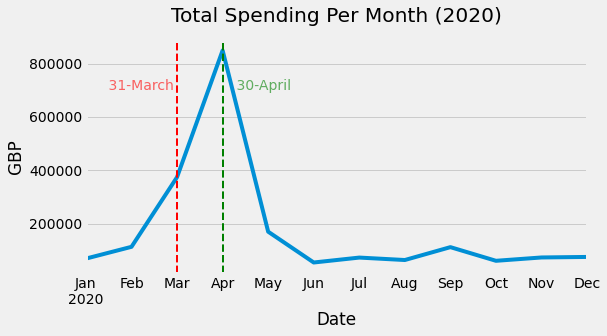

In [66]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(8,4))
plt.ylabel('GBP')
plt.title('Total Spending Per Month (2020)', y=1.05)
spend.set_index('Date').resample('M').sum().plot(y='Amount', ax=ax, legend=False)
plt.axvline(datetime(2020, 3, 31), linewidth=2, label='31-Mar-2020', color='red', linestyle='dashed')
ax.text(x=datetime(2020, 1, 31), y=700000, s='     31-March', alpha=0.6, color='red')
plt.axvline(datetime(2020, 4, 30), linewidth=2, label='30-April-2020', color='green', linestyle='dashed')
ax.text(x=datetime(2020, 4, 30), y=700000, s='   30-April', alpha=0.6, color='green')
plt.show()

In [67]:
spend.set_index('Date').resample('M').sum().to_html('spend_per_month.html')
spend.set_index('Date').resample('M').sum()

,Amount
Date,
2020-01-31,69975.66
2020-02-29,114075.87
2020-03-31,374932.91
2020-04-30,848943.78
2020-05-31,170649.78
2020-06-30,55387.16
2020-07-31,73797.24
2020-08-31,64645.95
2020-09-30,112831.16


### Top 20 Spending for January 2020 to December 2020 by Supplier

In [68]:
grouped = spend.groupby('supplier_fuzzy')

report = grouped.agg(
    total_spend_supplier=pd.NamedAgg(column='Amount', aggfunc='sum'),
    percent_share_spend=pd.NamedAgg(
        column='Amount',
        aggfunc=lambda x: round(np.sum(x) / total_spend * 100, 3)
    ),
    number_purchases=pd.NamedAgg(column='Amount', aggfunc='size'),
    first_purchase=pd.NamedAgg(column='Date', aggfunc='min'),
    last_purchase=pd.NamedAgg(column='Date', aggfunc='max')
)
report.sort_values('total_spend_supplier', ascending=False).head(20).to_html('top_20.html')
report.sort_values('total_spend_supplier', ascending=False).head(20)

,total_spend_supplier,percent_share_spend,number_purchases,first_purchase,last_purchase
supplier_fuzzy,,,,,
glove club,649316.99,30.959,42,2020-02-17,2020-09-25
robert peel,216000.00,10.299,1,2020-04-23,2020-04-23
arden winch,109854.72,5.238,13,2020-02-12,2020-04-20
global beauty,72656.64,3.464,5,2020-03-26,2020-04-08
tgs coachworks,71506.51,3.409,5,2020-04-16,2020-05-15
amazon,68137.13,3.249,73,2020-01-08,2020-12-24
sp beautiful brows,53158.48,2.535,7,2020-03-23,2020-04-22
sharp enright,44773.36,2.135,30,2020-01-21,2020-10-19
thomaskneale,30465.60,1.453,8,2020-09-09,2020-10-05


Let's focus on the first peak lockdown period.

### Top 20 Spending 01-Mar-2020 to 30-Apr-2020

A view only on spending during the first lockdown preparation and the chart spike.


In [69]:
spend[spend['Date'].between(datetime(2020,3,1), datetime(2020,4,30))].groupby('supplier_fuzzy').agg(
    total_spend_supplier=pd.NamedAgg(column='Amount', aggfunc='sum'),
    number_purchases=pd.NamedAgg(column='Amount', aggfunc='size'),
    first_purchase=pd.NamedAgg(column='Date', aggfunc='min'),
    last_purchase=pd.NamedAgg(column='Date', aggfunc='max')
).sort_values('total_spend_supplier', ascending=False).head(20)

,total_spend_supplier,number_purchases,first_purchase,last_purchase
supplier_fuzzy,,,,
glove club,527102.71,30,2020-03-02,2020-04-30
robert peel,216000.00,1,2020-04-23,2020-04-23
arden winch,92199.06,11,2020-03-02,2020-04-20
global beauty,72656.64,5,2020-03-26,2020-04-08
tgs coachworks,69619.15,3,2020-04-16,2020-04-23
sp beautiful brows,53158.48,7,2020-03-23,2020-04-22
amazon,22016.92,17,2020-03-03,2020-04-21
kvm serviced apartment,8585.00,3,2020-03-24,2020-04-08
apple,6876.00,1,2020-03-30,2020-03-30


In [70]:
spend.to_csv('cleaned_spend.csv', index=False)
report.to_csv('cleaned_agg_spend.csv')